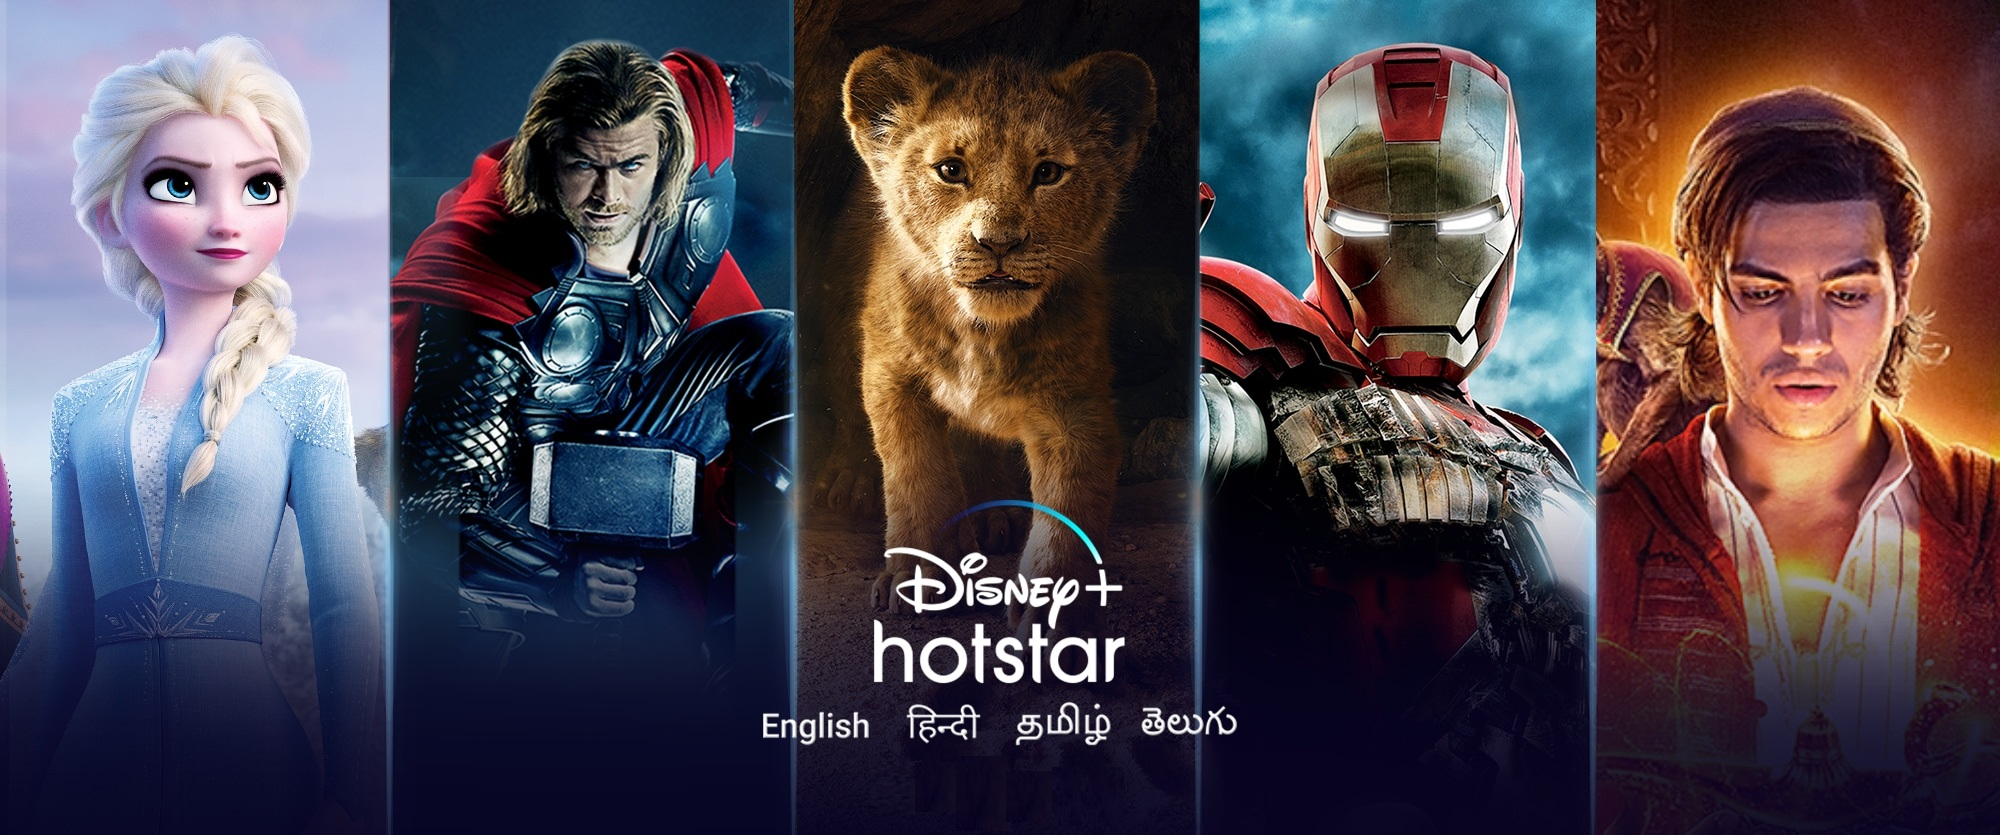

In [1]:
%%HTML

<div style = "text-align: justify;">

<div style = "font-family:Comic Sans MS;font-size:20px;color:#778899;text-align:center;" ><h2>MOVIE RECOMMENDER SYSTEM</h2></div><br>
<div style = "font-family:Comic Sans MS;font-size:18px;line-height: 1.6;color:#778899;text-align:justify;" >


The files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. 
The dataset consists of movies released on or before July 2017. Data points include cast, 
crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, 
countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. 
Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

</div><br>

<div style = "font-family:Comic Sans MS;font-size:20px;color:#778899;text-align:center;" ><h2>Top 12 Recommended movies related to movie title</h2></div><br>
</div>

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
import requests
import responses
from PIL import Image
import io
from ipywidgets import widgets, VBox, HBox, Box, HTML, Layout,interact
import json


df = pd.read_csv('movies.csv')
movies =df.copy()
#movies.head()
#print('shape of movies dataset',movies.shape)


df = pd.read_csv('credits.csv', usecols=['movie_id','title'])
credits = df.copy()
credits= credits.rename(columns={'movie_id':'id'},index=str)
#print('shape of credit dataset',credits.shape)


df = pd.read_csv('credits.csv')
credits = df.copy()
credits= credits.rename(columns={'movie_id':'id'},index=str)
#credits.head()
#print('shape of credit dataset',credits.shape)
  
    
merged_df = movies.merge(credits,on='id')
#merged_df .head(1)   

merged_df = merged_df.drop(['homepage','title_x','title_y','status','production_companies'],axis=1)

using_value_of_merged_df= merged_df[['id','original_title','overview','vote_average']]
#print(using_value_of_merged_df.shape)
#using_value_of_merged_df

indices = pd.Series(movies.index,index = using_value_of_merged_df['original_title'])
#type(indices)
indices = indices.drop_duplicates()
#print(indices.shape)
#indices


indices = pd.DataFrame(indices).reset_index()
indices= indices.rename(columns={0:'index_values'},index=str)
#indices
final_df = indices.merge(using_value_of_merged_df,on='original_title')
#final_df['index_values'] = final_df['index_values'].apply(str)
#final_df['id'] = final_df['id'].apply(str)
#final_df



tvf = TfidfVectorizer(min_df=3,
                      max_features=None,
                      strip_accents='unicode',
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1,3),
                      stop_words='english')

#imputing Nan values with empty strings

final_df['overview'] = final_df['overview'].fillna('')

tvf_matrix = tvf.fit_transform(final_df['overview'])
#print('tvf_matrix',tvf_matrix)
#print('Shape of tvf_matrix', tvf_matrix.shape)

sigmod = sigmoid_kernel(tvf_matrix,tvf_matrix)

def recommendation(title,sig=sigmod):
        
    final_val = final_df.loc[final_df['original_title'] == title]
    index  = final_val['index_values']
    
    # final_val['index_values'] --> this is returning the values as dataframe which sigmond fun is not accepting it accepts just integer value.
    # Converting pandas df value into list and fetcing value of zero index and passing to sigmod
    index = list(index)[0]
    sigmod_values = sigmod[index]

    sig_scores =  list(enumerate(sigmod_values)) 
    #print(sig_scores) 
        
        
    sig_scores = sorted(sig_scores,key = lambda x:x[1],reverse=True)
    sig_scores =sig_scores[1:13]
    
    #for movies in sig_scores:
    movies_indices = [i[0] for i in sig_scores]
    #print('movies_indice',movies_indices)
    
    return final_df[['original_title','id','vote_average']].iloc[movies_indices] 

In [3]:
result_df = ""
def returnRecommendedMovies(title):
    global result_df
    result_df = recommendation(title)
    return result_df


class RecommendedMovieClass:      
    def __init__(self, title, poster="None"):
        self.title = title
        if poster == 'None':
            self.poster = Image.open("placeholder_desaturated.jpg")
        else:
            self.poster = poster



menu = np.array(final_df['original_title'].values.tolist()) 
menu = np.unique(menu)

DropDown = widgets.Dropdown(options=menu,
    value='Spider-Man 2',
    description='<div style = "height:100px;width:70px;border-style:#;padding-bottom:10px;font-family:Trebuchet MS;font-size:15px;font-style:bold;font-color:#999999;"><b>Movies</b></div> :</br></br>',
)

# display(HTML('<br><br><br>'))



#======================================================================#
#======================================================================#
#==================Recommended Movie Posters===========================#
#======================================================================#

def gettingPosterthemoviedb():
    api_key = '1bbb69a25e7282f2c67c7b34d7042e21'
    language = 'en-US'
    recommended_movies = []
    placeholder = Image.open("placeholder_desaturated.jpg")
    result_df = returnRecommendedMovies(DropDown.get_interact_value())

    
    for i in result_df['id'].head(12):
        movie_id = str(i)
        url_get_poster_path ='https://api.themoviedb.org/3/movie/'+movie_id+'?api_key='+api_key+'&language='+language+''
        response = requests.get(url_get_poster_path)
        #print(response.status_code)
        #print(response.content)

        # Get the response data as a python object. Verify that it's a dictionary.
        try:
            data = response.json()

            #print(type(data))
            movie_title = data.get('original_title')
            poster_path = data.get('belongs_to_collection')['poster_path']

            if poster_path != 'None':
                url_get_poster ='https://image.tmdb.org/t/p/w200'+poster_path+''
                image = Image.open(requests.get(url_get_poster, stream=True).raw)
                recommended_movies.append(RecommendedMovieClass( movie_title, image))

        except Exception as e:
            recommended_movies.append( RecommendedMovieClass(movie_title) )
    
    return recommended_movies


#======================================================================#


def VBox(*pargs, **kwargs):
    """Displays multiple widgets vertically using the flexible box model."""
    box = Box(*pargs, **kwargs)
    box.layout.display = 'flex'
    box.layout.flex_flow = 'column'
    box.layout.align_items = 'stretch'
    return box

def HBox(*pargs, **kwargs):
    """Displays multiple widgets horizontally using the flexible box model."""
    box = Box(*pargs, **kwargs)
    box.layout.display = 'flex'
    box.layout.align_items = 'stretch'
    return box


#======================================================================#

def make_box_for_grid(image_widget, fit):
    """
    Make a VBox to hold caption/image for demonstrating
    option_fit values.
    """
    # Make the caption
    fit_str = str(fit)

    h = HTML(value='' + str(fit_str) + '')

    # Make the green box with the image widget inside it
    boxb = Box()
    boxb.layout = Layout()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = VBox()
    vb.layout.align_items = 'center'
    vb.children = [h, boxb]
    return vb
#======================================================================#

def displayRow(box):
    sidebyside = widgets.HBox(box)
    display(sidebyside);
    return

def getImageWidgetList(recommended_movies):
    widgetList = []
    for movie in recommended_movies:
        byteIO = io.BytesIO()
        movie.poster.save(byteIO, format='JPEG')
        widgetList.append(widgets.Image(value=byteIO.getvalue(), width=200, height=300))
        
    return widgetList
    
def getImageBoxes(widgetList, recommended_movies):
    boxes = []
    i = 0
    #print ("Length widgetList: ", len(widgetList))
    #print ("Length movieTitles: ", len(recommended_movie_titles))
    while(i < len(widgetList)):
        boxes.append(make_box_for_grid(widgetList[i], recommended_movies[i].title))
        i= i+1
    return boxes    
 
def  displayRecommendedPosterGrid(boxes):
    box1 = boxes[0:4]
    box2 = boxes[4:8]
    box3 = boxes[8::]
    
    displayRow(box1);
    displayRow(box2);
    displayRow(box3);
    return

    
def displayRecommendedMovieList():
    recommended_movies = gettingPosterthemoviedb()
        
    widgetList = getImageWidgetList(recommended_movies)
    boxes = getImageBoxes(widgetList, recommended_movies)
    displayRecommendedPosterGrid(boxes);
    return
#======================================================================#
#================End of recommended movie poster display===============#
#======================================================================#

In [4]:
def highlight_col(x):
    original_title = 'background-color: #ccebff'
    Ratings =        'background-color: #ccebff'

    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, 0] = original_title
    df1.iloc[:, 1] = Ratings
    return df1



def show_recommended_movies(title): 
    showDataFrame = returnRecommendedMovies(title)
    
    pd.options.display.float_format = '{:.1f}'.format
    #showDataFrame = result_df.copy()
    showDataFrame = showDataFrame.drop(['id'],axis=1)
    showDataFrame= showDataFrame.rename(columns={'original_title':'Movies','vote_average':'Ratings'})
    th_props = [
         ('font-size', '20px'),
         ('text-align', 'center'),
         ('font-weight', 'bold'),
         ('color', '#999999'),
         ('background-color', '#f7f7f9')
     ]

    # Set table styles
    styles = [
        dict(selector="th", props=th_props)
    ]
    s = showDataFrame.style.apply(highlight_col, axis=None) 
    s = s.hide_index()
    s.set_table_styles(styles)
    s.set_properties(**{'border-style': 'solid',
                        'border-color': '#e0e0eb',
                        'border-width':'0.015px',
                        'color': 'black',
                        'font-family':'Trebuchet MS',
                        'font-weight':'bold',
                        'text-align':'center',
                        'width':'395px'
                           })
    s.set_precision(1)
    #s = s.set_caption('<h2>TOP FIVE RECOMMENDED MOVIES RELATED TO TITLE</h2><br>')
    pd.option_context('display.colheader_justify','center')
    
    display(HTML('<br>'))
    display(s);
    display(HTML('<br>'))
    displayRecommendedMovieList();
#     return s

DropDown.layout.height = '40px'
interact(show_recommended_movies, title=DropDown);
# displayRecommendedMovieList();


interactive(children=(Dropdown(description='<div style = "height:100px;width:70px;border-style:#;padding-botto…

In [5]:
display(HTML(
    
            '<html>'
                '<head>'
                         '<style>'
                                'a:link {color: #0000ff;}'              # unvisited link
                                'a:visited {color: #778899;}'           # visited link 
                                'a:hover {color: #2eb82e;}'            # mouse over link
                                'a:active {color: #00ff00;}'          # selected link 
                       '</style>'
                    '</head>'
                '<body>'

                    '<div style = "font-family:Comic Sans MS;font-size:20px;color:#778899;line-height: 1.7;text-align: justify;">'+

                        '<h2>Notebook covers:</h2>'
                         
                            '1. Context.<br>'+
                            '2. Content.<br>'+
                            '3. Data Cleaning and Preparation.<br>'+
                            '4. Tokenization of data into words.<br>'+
                            '5. Using Tfidf Vectorizer for Content based movie Recomendation.<br>'+
                            '6. Calling API The movie DB for fetching pictures related to the movies.<br>'+
                            '7. Recomending movies related to movie title.</li><br>'
                        
                '</div>'
          '</body>'
        '</html>'
  

        ))
    


HTML(value='<html><head><style>a:link {color: #0000ff;}a:visited {color: #778899;}a:hover {color: #2eb82e;}a:a…

In [6]:
%%HTML
</div>
<div style = "font-family:Comic Sans MS, Courier, monospace;font-size:20px;color:#778899;line-height: 1.7;text-align: justify;">
<h2>More Info Datasets visit the below given url:</h2>
<a style="text-decoration:none" href = https://grouplens.org/datasets/movielens/latest/> https://grouplens.org/datasets/movielens/latest/ </a><br>
<a style="text-decoration:none" href = https://www.imdb.com/>https://www.imdb.com/</a><br>
<a style="text-decoration:none" href = https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/>https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/</a> 
</div>


In [8]:
#!pip freeze > requirements.txt